# Polynomial approximation
<!-- # 多項式近似 -->

- So far, we use linear interpolation or spline interpolation to approximate the value function or the policy function in the next period
<!-- - これまでは、次期の価値関数や政策関数を近似するのに、線形補間やスプライン補間を用いた -->

- Each of interpolations approximates values between the grid dividing the state space. We want to approximate the entire state space by a single polynomial 
<!-- - これらの補間は、いずれも状態空間を分割するグリッドの間を異なる関数で近似するが、今度は状態空間全体を一つの多項式(polynomial)で近似する -->

- Now the following is the true function we want to know:
<!-- - いま、 -->

$$
  y=g(x)=\frac{1}{1+x^{2}}, x \in [-5,5]
$$

<!-- が我々が知りたい真の関数であるとする -->

- However, we do not know the true function, but only information about the function on 11 points
<!-- - しかし、我々はその真の姿を知らず、11個の点の情報だけを持っているとしよう -->

In [1]:
using Plots
using Dierckx # not supported by CoCalc

In [2]:
function f(x0)
    
    nx = size(x0,1)
    f0 = 1 ./ (1 .+ 25*x0.^2)
    
    return f0
    
end

f (generic function with 1 method)

In [17]:
# data points
xmin = -1
xmax = 1
nxd = 11
xd = collect(LinRange(xmin, xmax, nxd))
yd = f(xd)

# functional values
nx = 1001
x0 = collect(LinRange(xmin, xmax, nx))
y0 = f(x0);

┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\takeki\.julia\packages\Plots\sxUvK\src\args.jl:1149


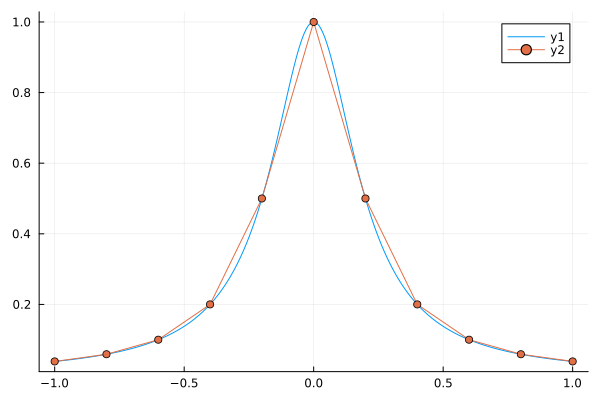

In [11]:
plot(x0,y0)
plot!(xd,yd,marker=:"circle")

In [18]:
## approximation by linear interpolation using Julia's function Spline1D
y1interp = Spline1D(xd,yd,k = 1, bc = "extrapolate")
x1 = collect(LinRange(xmin, xmax, nx))
y1 = y1interp(x1);

## approximation by usual polynomials
Xd = ones(nxd,nxd)
X2 = ones(nx,nxd)
x2 = x1
for i=1:nxd-1
    Xd[:,i+1] = xd.^i
    X2[:,i+1] = x2.^i
end

b = (Xd'*Xd)\(Xd'*yd)
y2 = X2*b;

- The approximated function with these 11 points by linear interpolation is the solid line in the figure below
<!-- - この11個の点を線形補間を使って近似すると下図の太線のようになる -->

- As the dots are connected by linear lines, there are kinks on the dots and the function is non-differentiable
<!-- - 点と点の間を直線で結んでいるため、点の上で屈折しており、微分不可能になっている -->

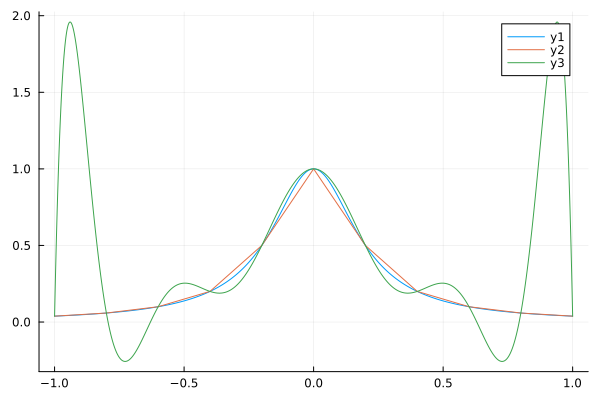

In [7]:
plot(x0,y0)
plot!(x1,y1)
plot!(x2,y2)

- We use the following 10th order polynomial to interpolate the 11 points
<!-- - 一方、次のような10次の多項式を用いて11個の点の間を補間する -->

$$
  g(x;\mathbb{\theta}) = \theta_{0}+\theta_{1}x+\theta_{2}x^{2}+\cdots+\theta_{10}x^{10}
$$

where we can calculate the values of 11 unknown coefficients by using the information on the 11 points
<!-- ここで、11つの未知の係数に対して11個の点の情報を用いて係数の値を求めることができる -->

- However, due to multicollinearity, the precision of approximation is not good especially at the edges of the graph
<!-- - しかし、多重共線性(multicollinearity)などから、とくにグラフの両端において多項式の近似の精度はよくない -->

## Chebyshev polynomial
<!-- ## チェビシェフ多項式 -->

- Chebyshev polynomial is often used instead of usual polynomials
<!-- - 通常の多項式の代わりによく用いられるのが、チェビシェフ多項式(Chebyshev polinomial)である -->

$$
  g(x;\mathbb{\theta}) = \theta_{0}+\theta_{1}T_{1}(x)+\theta_{2}T_{2}(x)+\cdots+\theta_{N-1}T_{N-1}(x)
$$

where $T_{i}(x):[-1,1]\rightarrow[-1,1]$ for $i=1,2,...,N-1$ is called the basis function
<!-- は基底関数(basis function)と呼ばれる -->

- The basis functions are recursively written as follows
<!-- - 基底関数は次のように再帰的に書ける -->

\begin{align*}
  T_{0}(x) &= 1, \\
  T_{1}(x) &= x, \\
  T_{2}(x) &= 2x^{2}-1, \\
  \vdots & \\
  T_{N-1}(x) &= 2xT_{N-2}(x)-T_{N-3}(x), \\
\end{align*}

- To obtain the parameters $\mathbb{\theta}=[\theta_{0},...,\theta_{N-1}]$ by fitting Chebyshev polynomials to data, N evaluation points are used
<!-- - チェビシェフ多項式をデータにフィットさせてパラメータ$\mathbb{\theta}=[\theta_{0},...,\theta_{N-1}]$を求めるには、N個の評価点$x_{j},j=0,1,...,N-1$を用いる -->

- There are two types of evaluation points
<!-- - 評価点には2種類ある -->

Chebyshev zeros: the solution of $T_{N-1}(x)=0$ and $x_{0}=0$
<!-- チェビシェフゼロ点(Chebyshev zeros)：$T_{N-1}(x)=0$の解および$x_{0}=0$ -->

\begin{align*}
  x_{0} &= 0, \\
  x_{j} &= \cos\big(\frac{(2j-1)\pi}{2(N-1)}\big)
\end{align*}

Chebyshev extrema: the solution of $|T_{N-1}(x)|=1$
<!-- チェビシェフ極値点(Chebyshev extrema)：$|T_{N-1}(x)|=1$の解 -->

$$
  x_{j} = \cos\big(\frac{j\pi}{N-1}\big)
$$

In [13]:
function polygrid(kmin,kmax,N)
    
#    temp = collect(LinRange(0,N-1,N))
#    x = -cos.((pi/(N-1))*temp) # Chebyshev extrema
    temp = collect(LinRange(1,N-1,N-1))
    x = [0; -cos.((pi/2/(N-1))*(2*temp .- 1))] # Chebyshev zeros
    
    # transformation from x to k
    k = 0.5*(kmax-kmin)*(x .+ 1) .+ kmin
   
    return k
    
end

polygrid (generic function with 1 method)

In [14]:
function polybas(kmin,kmax,Np,kgrid)
    
    # Np: the order of polynomials-1
    # Ng: the number of grid points
    Ng = size(kgrid,1)
    x = (2/(kmax-kmin))*(kgrid .- kmin) .- 1
    
    # recursively obtain the matrix of the basis functions
    T = zeros(Ng,Np)
    T0 = ones(Ng)
    T1 = x
    T2 = 2*x.*T1 - T0
    T[:,1] = T1
    T[:,2] = T2
    
    for i=3:Np-1
        T[:,i] = 2*x.*T[:,i-1] - T[:,i-2] 
    end
    
    T = [T0 T[:,1:(Np-1)]]
    
    return T
    
end

polybas (generic function with 1 method)

- The values of Chebyshev polynomials evenly cover the space. It is not like usual polynomials
<!-- - 通常の多項式と異なり、チェビシェフ多項式は、関数の値が空間を満遍なく覆っていることがわかる -->

- Once we know the evaluation points $x_{j}$ and the values of the function at the point $g(x_{j})$, by fitting the polynomial $g(x_{j};\mathbf{\theta})$ to the values of the function, we can obtain the parameters $\mathbf{\theta}$
<!-- - 評価点$x_{j}$とその点における関数の値$g(x_{j})$がわかると、多項式$g(x_{j};\mathbf{\theta})$を関数の値にフィットさせることで、パラメータ$\mathbf{\theta}$が得られる -->

$$
  \left[\begin{array}{c} g(x_{0}) \\ g(x_{1}) \\ \vdots \\ g(x_{N-1}) \end{array}\right]
  = \left[\begin{array}{ccccc} 1 & T_{1}(x_{0}) & T_{2}(x_{0}) & \cdots & T_{N-1}(x_{0}) \\
   1 & T_{1}(x_{1}) & T_{2}(x_{1}) & \cdots & T_{N-1}(x_{1}) \\
   \vdots & \vdots & \vdots & \ddots & \vdots \\
   1 & T_{1}(x_{N-1}) & T_{2}(x_{N-1}) & \cdots & T_{N-1}(x_{N-1})
   \end{array}\right]
   \left[\begin{array}{c} \theta_{0} \\ \theta_{1} \\ \vdots \\ \theta_{N-1} \end{array}\right]
$$

Or,
<!-- または、 -->

$$
  g(\mathbf{x}) = T(\mathbf{x})\mathbf{\theta}
$$

where $\mathbf{x}=[x_{0},\dots,x_{N-1}]$. If the matrix $T(\mathbf{x})$ is nonsingular, we can obtain $\mathbf{\theta} = T(\mathbf{x})^{-1}g(\mathbf{x})$
<!-- ここで、$\mathbf{x}=[x_{0},\dots,x_{N-1}]$である。もし行列$T(\mathbf{x})$が正則であれば、$\mathbf{\theta} = T(\mathbf{x})^{-1}g(\mathbf{x})$が求まる -->

- If the matrix $T(\mathbf{x})$ is nearly singular or ill-conditioned, the computation of the inverse matrix includes larger error 
<!-- - 行列$T(\mathbf{x})$が非正則に近い悪条件(ill-conditioned)になる場合、逆行列の計算結果に含まれる誤差が大きくなる -->


- However, the matrix made by Chebyshev basis function and its evaluation points is known to be orthogonal and nonsingular
<!-- - しかし、チェビシェフ基底関数とその評価点によって作られる行列は直交条件を満たし、正則になることが知られている -->


- Also, after choosing the basis function and evaluation points, the matrix $T(\mathbf{x})$ is fixed 
<!-- - また、行列$T(\mathbf{x})$は、ひとたび基底関数と評価点を選ぶとその後は固定される -->


- Therefore, by computing the inverse matrix at the beginning of the algorithm, we can save computation time
<!-- - 逆行列$T(\mathbf{x})^{-1}$の計算をアルゴリズムの初期にあらかじめ行っておくことで、計算時間を節約できる -->

- If we want to approximate a general function $g(k):[k_{1},k_{N}] \rightarrow \mathbb{R}$ by Chebyshev polynomials, the following transformation $\varphi(k):[k_{1},k_{N}] \rightarrow [-1,1]$ is used
<!-- - 一般的な関数$g(k):[k_{1},k_{N}] \rightarrow \mathbb{R}$をチェビシェフ多項式で近似したい場合、以下の変換$\varphi(k):[k_{1},k_{N}] \rightarrow [-1,1]$を用いる -->

$$
  x_{j} = \varphi(k_{j}) = \frac{2(k_{j}-k_{1})}{k_{N}-k_{1}}-1
$$

And we obtain the following polynomial
<!-- そして以下のような多項式を得る -->

$$
  g(k;\mathbb{\theta}) = \theta_{0}+\theta_{1}T_{1}(\varphi(k))+\theta_{2}T_{2}(\varphi(k))+\cdots+\theta_{N-1}T_{N-1}(\varphi(k))
$$

- The approximation by Chebyshev polynomials and evaluation points improves the precision of approximation, compared to the one with usual polynomials and evenly spaced grid points
<!-- - チェビシェフ多項式と評価点を用いた近似で、通常の多項式と等間隔のグリッドを用いた近似に比べて、近似の精度が改善している -->

In [ ]:
# # approximation by Chebyshev polynomials
# N=11
nxd = 11
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)
theta = T\ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3*theta;

# # approximation by Chebyshev polynomials
# # N=21
# nxd = 21
# xcheb = polygrid(xmin,xmax,nxd)
# ycheb = f(xcheb)
# T = polybas(xmin,xmax,nxd,xcheb)
# theta = T\ycheb

# x3 = x1
# T3 = polybas(xmin,xmax,nxd,x3)

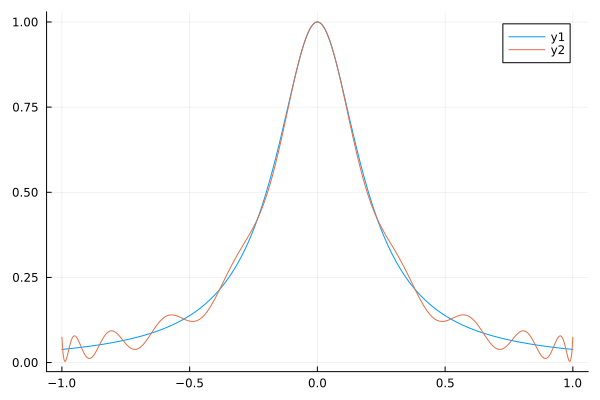

In [19]:
# # approximation by Chebyshev polynomials
# N=11
nxd = 21
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)
theta = T\ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3*theta;

# # approximation by Chebyshev polynomials
# # N=21
# nxd = 21
# xcheb = polygrid(xmin,xmax,nxd)
# ycheb = f(xcheb)
# T = polybas(xmin,xmax,nxd,xcheb)
# theta = T\ycheb

# x3 = x1
# T3 = polybas(xmin,xmax,nxd,x3)
# y3 = T3*theta;

plot(x0,y0)
plot!(x3,y3)